<a href="https://colab.research.google.com/github/JJThoms1/04_transfer_learning_in_tensorflow_part_1_feature_extraction/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learning patterns for our own problems.

There are two main benefits:
1. Can leverage an axisting neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
# Are we using a GPU?
!nvidia-smi

Thu Oct  3 10:24:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Get data (10% of 10 food classes from Food101) - https://www.kaggle.com/datasets/dansbecker/food-101
import zipfile
import os

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Check if the file exists
if not os.path.exists("10_food_classes_10_percent.zip"):
    print("Error: File not found. Please download the file again.")
else:
  # Unzip the download file
  zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
  zip_ref.extractall()
  zip_ref.close()

--2024-10-03 10:24:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.207, 74.125.20.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   247MB/s    in 0.7s    

2024-10-03 10:24:31 (247 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [3]:
# How many images in each folder
import os

# Walk through 10 percent of data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during and after training. Some of the most popular callbacks are:

* Tracking experiments with the TensorBoard callbacks
* Model checkpoint with ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [5]:
# Create TensorBoard callback (functionalized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

🔑 **Note:** You can customize the directory where your TensorBoard logs(model training metrics) get saved to wherever you like. The log_dir parameter we've created above is only one option.

In [6]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

## Creating models using TensorFlow Hub

In the past we've used Tensorflow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained model on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://www.kaggle.com/models/tensorflow/efficientnet

In [7]:
!pip install tensorflow==2.11.0
!pip install tensorflow-hub==0.12.0
!pip install tf_keras==2.11.0

ERROR: Could not find a version that satisfies the requirement tf_keras==2.11.0 (from versions: 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1rc0, 2.15.1, 2.16.0rc0, 2.16.0rc1, 2.16.0rc2, 2.16.0rc3, 2.16.0rc4, 2.16.0, 2.17.0rc0, 2.17.0, 2.18.0rc0)
ERROR: No matching distribution found for tf_keras==2.11.0


In [8]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
# Let's make our create_model() function to create a model from a URL
def create_model(model_url, num_classes=10, input_shape=(224, 224)):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs neurons.
  """
  IMAGE_SHAPE = input_shape
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create the model
  model = tf.keras.Sequential([
     feature_extractor_layer, # Add the feature extraction layer
     layers.Dense(num_classes, activation="softmax", name="output_layer") # Add the output layer
  ])

  return model

### Creating and testing ResNet TensorFlow Hub feature Exraction model.

In [10]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [11]:
# Compile the model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [12]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [13]:
# Let's fit our ResNet model to the data (10% of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                        experiment_name="resnet50V2"
                                                                        )])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20241003-102450
Epoch 1/5
24/24 [==============================] - 494s 21s/step - loss: 1.8592 - accuracy: 0.3907 - val_loss: 1.1185 - val_accuracy: 0.6556
Epoch 2/5
24/24 [==============================] - 486s 21s/step - loss: 0.8652 - accuracy: 0.7560 - val_loss: 0.8175 - val_accuracy: 0.7360
Epoch 3/5
24/24 [==============================] - 471s 20s/step - loss: 0.6090 - accuracy: 0.8307 - val_loss: 0.7387 - val_accuracy: 0.7572
Epoch 4/5
24/24 [==============================] - 468s 20s/step - loss: 0.4642 - accuracy: 0.8787 - val_loss: 0.6749 - val_accuracy: 0.7900
Epoch 5/5
24/24 [==============================] - 491s 21s/step - loss: 0.3714 - accuracy: 0.9227 - val_loss: 0.6605 - val_accuracy: 0.7828


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out preformed all of the previous models we built by hand... (substantially) and in a quicker training time. And with only 10% of the training examples.

In [15]:
# Let's create a function to plot our loss curves
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

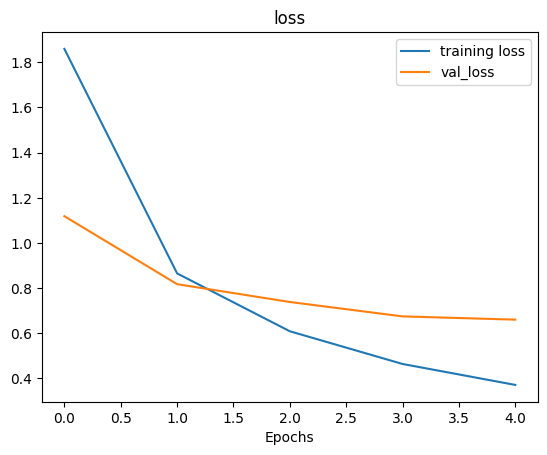

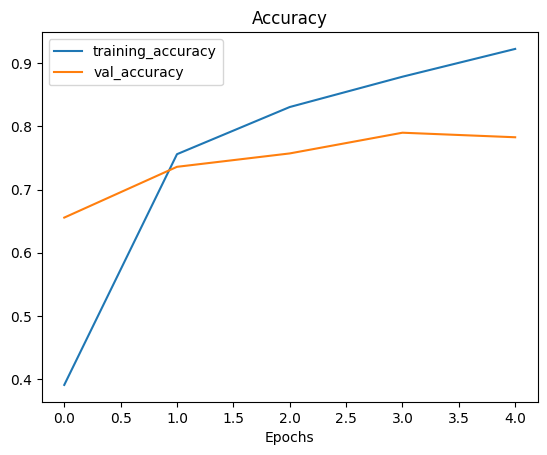

In [16]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub feature Exraction model.